In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from numba import double
from numba.decorators import jit

import sys
sys.path.append('../')


In [47]:
from src.plots import plot_map
from src.synthetic_datasets import generate_model, generate_dataset


# Parameters

In [42]:
matplotlib.rcParams.update({'font.size': 15})

size_model = 5
size_data = 40

m_mean = 10
m_std = 2

# Build dataset

## Real model

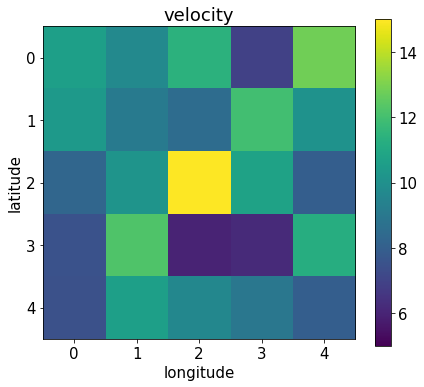

In [35]:
c = generate_model(size_model, m_mean, m_std, seed=389)
plot_map(c, vmin=5, vmax=15, title='velocity')


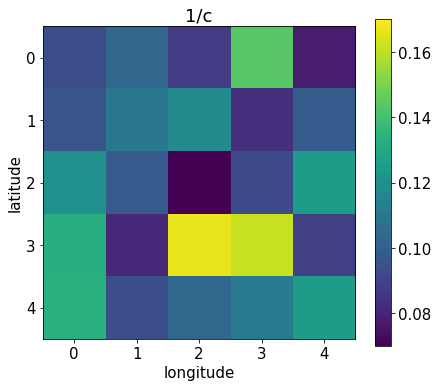

In [36]:
m = [[1/val for val in row] for row in c]
plot_map(m, vmin=0.07, vmax=0.17, title='1/c')


## Dataset
A data consist in the path between two points (p1, p2) = ((lat, lon), (lat,lon))

In [50]:
dataset = generate_dataset(size_data, size_model, min_lenght=3, seed=89)
print(len(dataset))

40


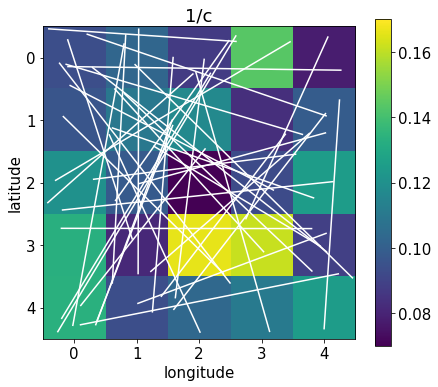

In [52]:
plot_map(m, dataset, vmin=0.07, vmax=0.17, title='1/c')

## Get the time spent in each cell by a data

In [53]:
def plot_data(m, data):
    plt.figure(figsize=(7,6))
    plt.imshow(m, vmin=0.07, vmax=0.17)
    plt.colorbar()
    plt.plot(data[:, 1], data[:, 0], c='white')
    
    for point in get_points(data):
        plt.scatter(point[1], point[0], c='r', s=10)
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()


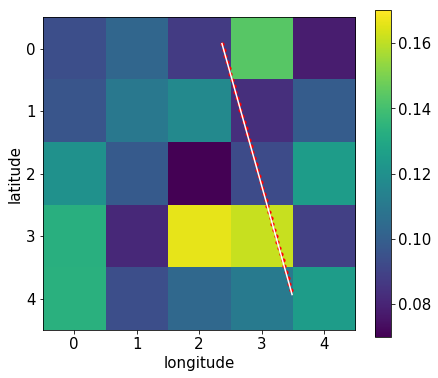

[[0.  0.  0.5 0.2 0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  1.1 0. ]
 [0.  0.  0.  0.4 0. ]]


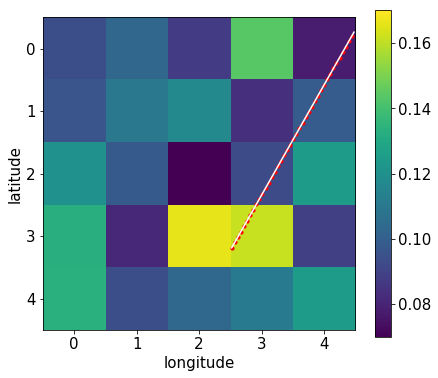

[[0.  0.  0.  0.  0.9]
 [0.  0.  0.  0.  1.1]
 [0.  0.  0.  1.2 0. ]
 [0.  0.  0.  0.8 0. ]
 [0.  0.  0.  0.  0. ]]


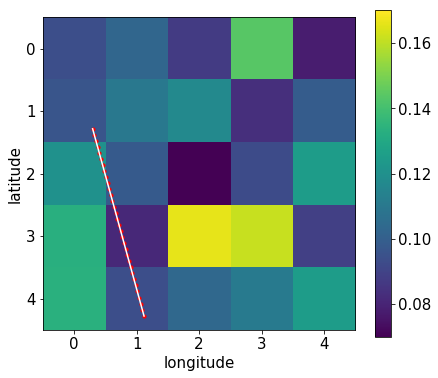

[[0.  0.  0.  0.  0. ]
 [0.3 0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.9 0.  0.  0. ]]


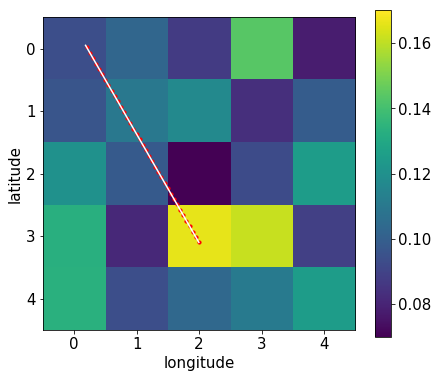

[[0.6 0.  0.  0.  0. ]
 [0.  1.2 0.  0.  0. ]
 [0.  0.9 0.3 0.  0. ]
 [0.  0.  0.7 0.  0. ]
 [0.  0.  0.  0.  0. ]]


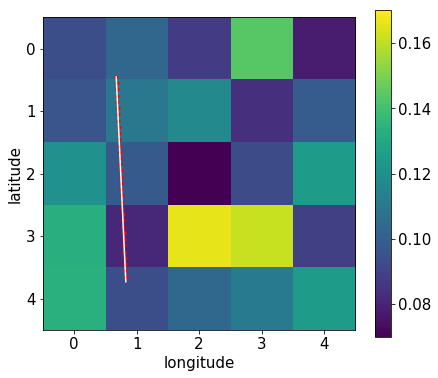

[[0.  0.1 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.2 0.  0.  0. ]]


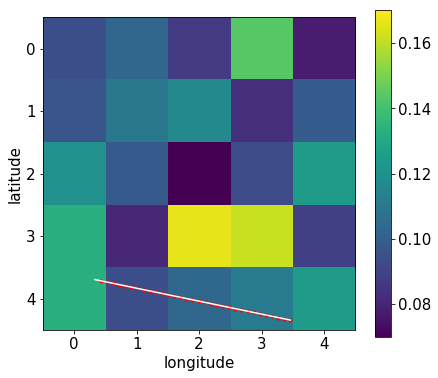

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.1 1.  1.1 1.  0. ]]


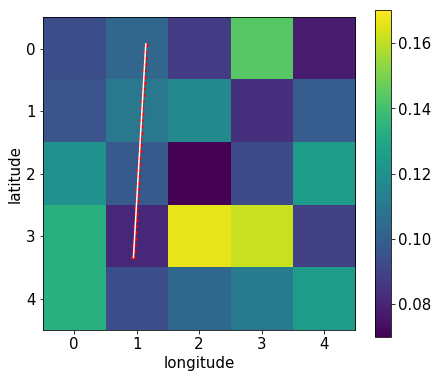

[[0.  0.6 0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.9 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


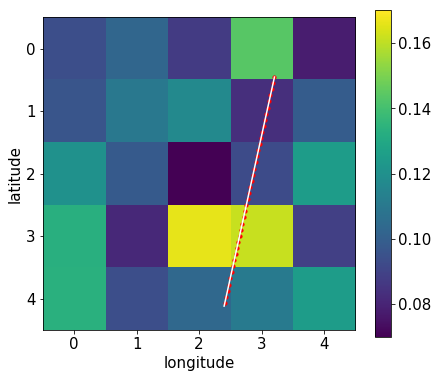

[[0.  0.  0.  0.1 0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  1.1 0. ]
 [0.  0.  0.5 0.1 0. ]]


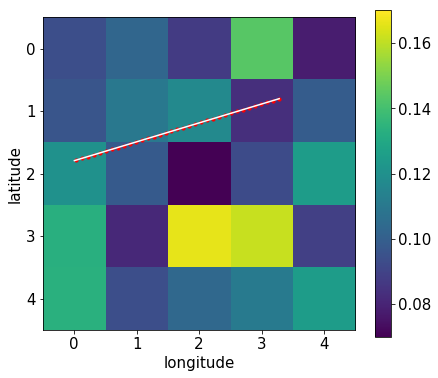

[[0.  0.  0.  0.  0. ]
 [0.  0.6 1.  0.9 0. ]
 [0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


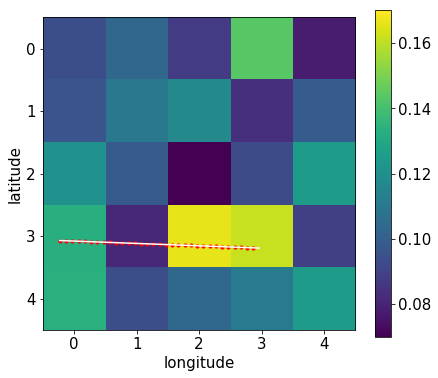

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.8 1.  1.  0.4 0. ]
 [0.  0.  0.  0.  0. ]]


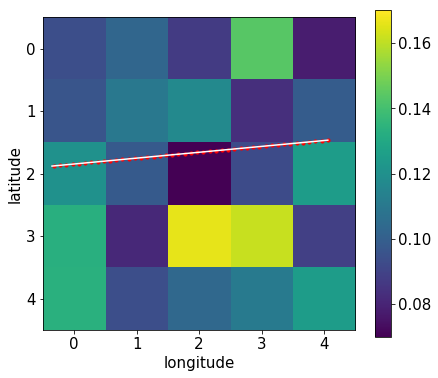

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.4]
 [0.9 1.  1.  1.  0.2]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


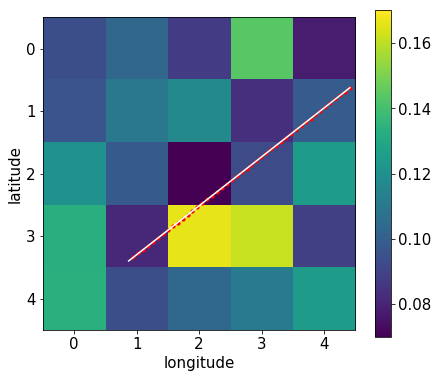

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.3 1.2]
 [0.  0.  0.6 1.  0. ]
 [0.  0.7 0.7 0.  0. ]
 [0.  0.  0.  0.  0. ]]


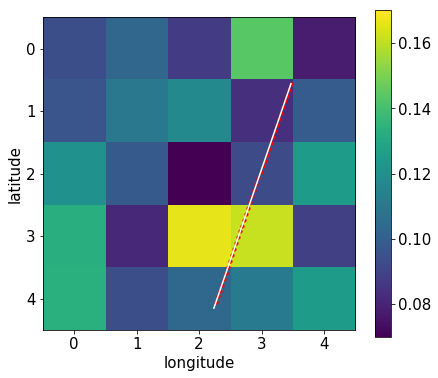

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0. ]
 [0.  0.  0.  1.1 0. ]
 [0.  0.  0.2 0.9 0. ]
 [0.  0.  0.6 0.  0. ]]


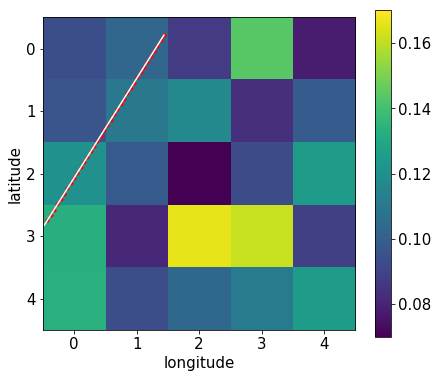

[[0.  0.9 0.  0.  0. ]
 [0.3 0.9 0.  0.  0. ]
 [1.2 0.  0.  0.  0. ]
 [0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


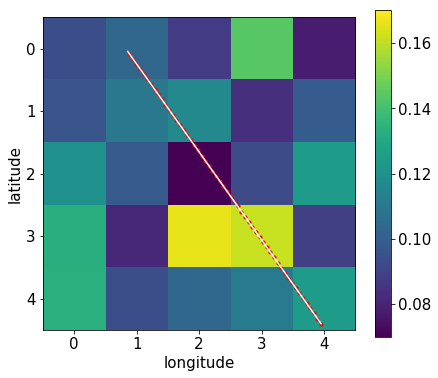

[[0.  0.6 0.  0.  0. ]
 [0.  0.5 0.7 0.  0. ]
 [0.  0.  1.  0.2 0. ]
 [0.  0.  0.  1.2 0. ]
 [0.  0.  0.  0.4 0.8]]


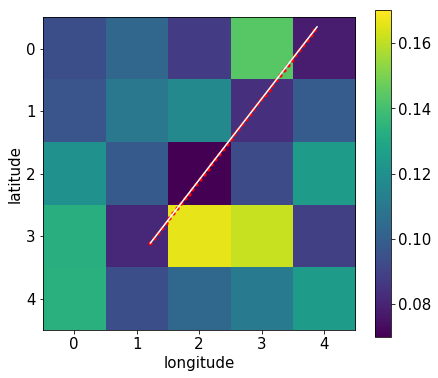

[[0.  0.  0.  0.5 0.6]
 [0.  0.  0.  1.2 0. ]
 [0.  0.  1.3 0.  0. ]
 [0.  0.5 0.3 0.  0. ]
 [0.  0.  0.  0.  0. ]]


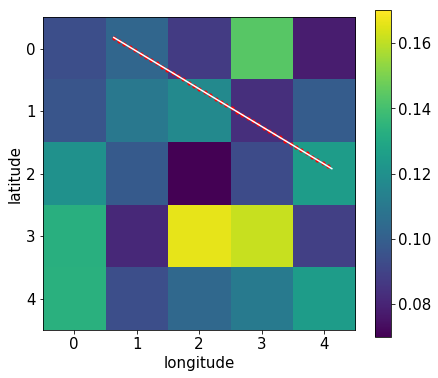

[[0.  1.1 0.3 0.  0. ]
 [0.  0.  0.8 1.1 0. ]
 [0.  0.  0.  0.1 0.7]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


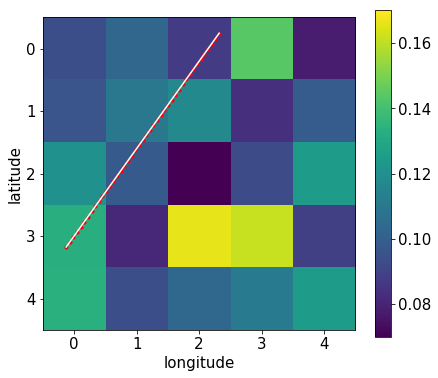

[[0.  0.  1.  0.  0. ]
 [0.  0.7 0.5 0.  0. ]
 [0.2 1.  0.  0.  0. ]
 [0.9 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


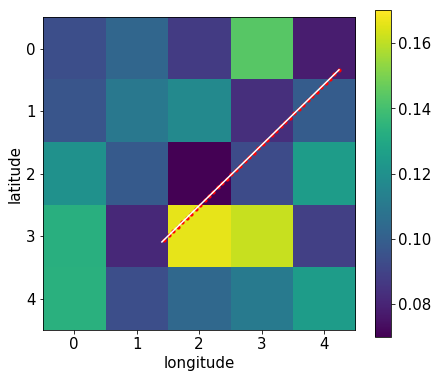

[[0.  0.  0.  0.  0.3]
 [0.  0.  0.  0.6 0.8]
 [0.  0.  0.6 0.8 0. ]
 [0.  0.1 0.8 0.  0. ]
 [0.  0.  0.  0.  0. ]]


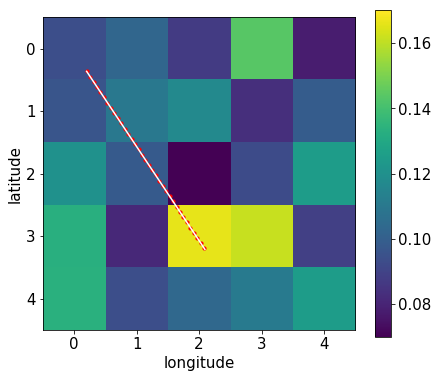

[[0.2 0.  0.  0.  0. ]
 [0.4 0.8 0.  0.  0. ]
 [0.  1.  0.2 0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [0.  0.  0.  0.  0. ]]


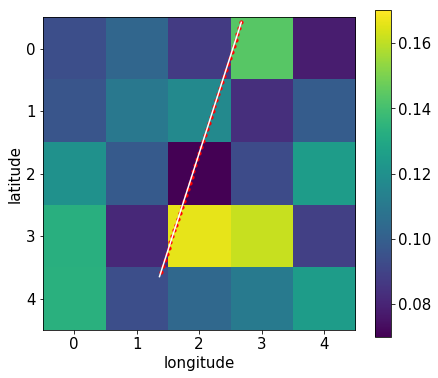

[[0.  0.  0.4 0.6 0. ]
 [0.  0.  1.1 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.3 0.8 0.  0. ]
 [0.  0.1 0.  0.  0. ]]


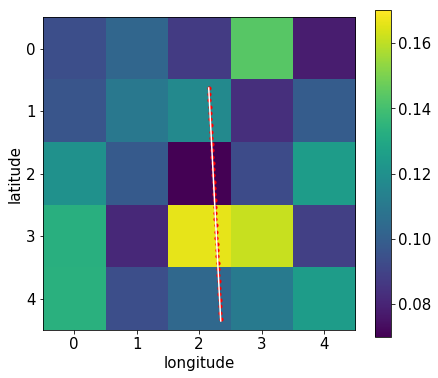

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.9 0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  1.  0.  0. ]
 [0.  0.  0.9 0.  0. ]]


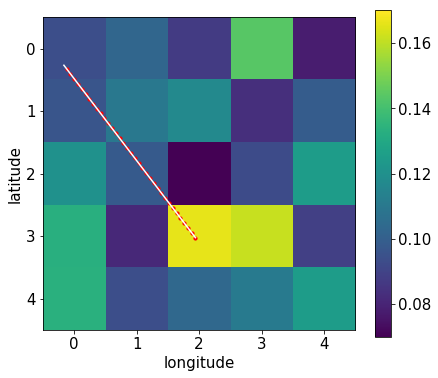

[[0.3 0.  0.  0.  0. ]
 [0.8 0.4 0.  0.  0. ]
 [0.  1.2 0.1 0.  0. ]
 [0.  0.  0.7 0.  0. ]
 [0.  0.  0.  0.  0. ]]


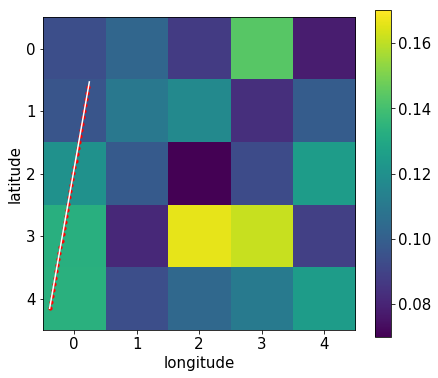

[[0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0. ]
 [0.7 0.  0.  0.  0. ]]


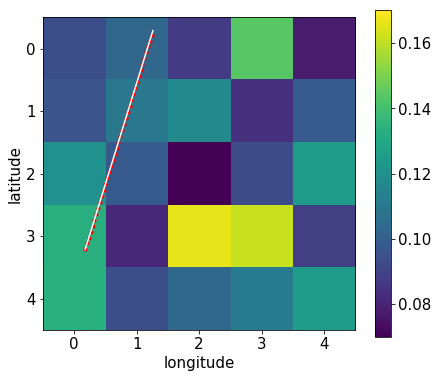

[[0.  0.8 0.  0.  0. ]
 [0.  1.1 0.  0.  0. ]
 [0.3 0.7 0.  0.  0. ]
 [0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


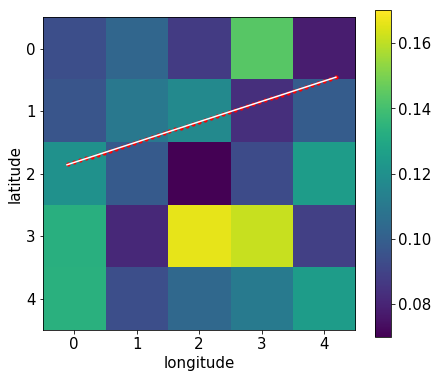

[[0.  0.  0.  0.  0.2]
 [0.  0.5 1.1 1.  0.6]
 [0.7 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


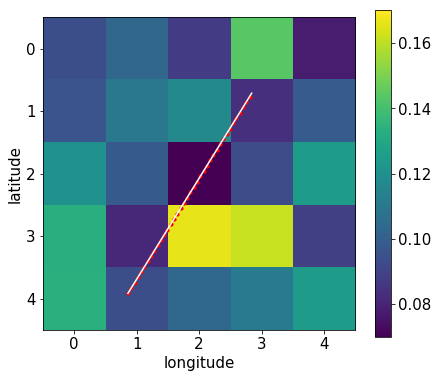

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.3 0.6 0. ]
 [0.  0.  1.2 0.  0. ]
 [0.  0.8 0.4 0.  0. ]
 [0.  0.5 0.  0.  0. ]]


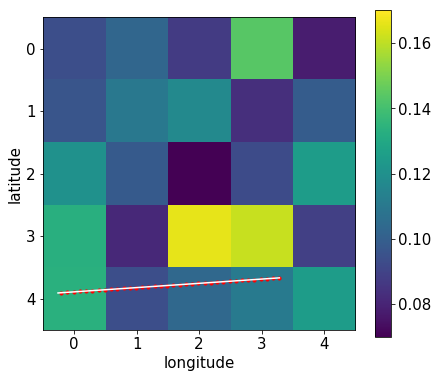

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.8 1.  1.  0.8 0. ]]


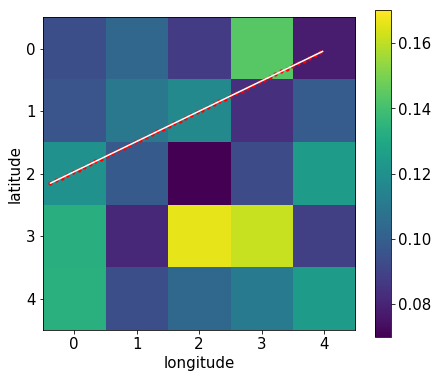

[[0.  0.  0.  0.6 0.5]
 [0.  0.6 1.1 0.6 0. ]
 [1.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


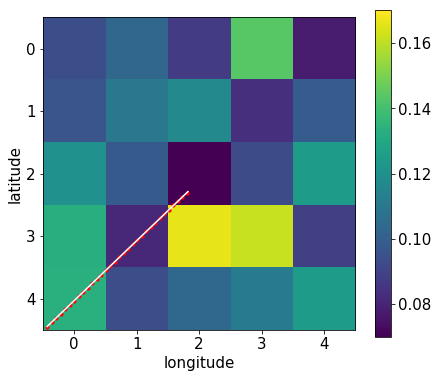

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.3 0.  0. ]
 [0.  1.3 0.2 0.  0. ]
 [1.3 0.1 0.  0.  0. ]]


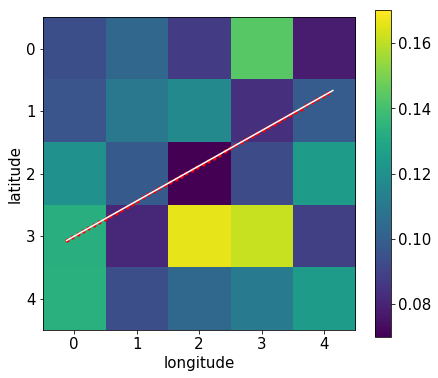

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.7]
 [0.  0.7 1.2 0.1 0. ]
 [0.8 0.4 0.  0.  0. ]
 [0.  0.  0.  0.  0. ]]


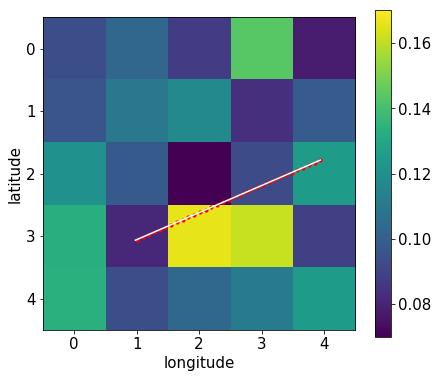

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.3 1.1 0.5]
 [0.  0.6 0.8 0.  0. ]
 [0.  0.  0.  0.  0. ]]


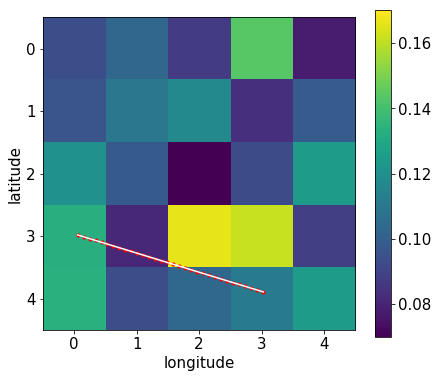

[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.5 1.1 0.2 0.  0. ]
 [0.  0.  0.8 0.6 0. ]]


In [54]:
@jit(nopython=True)
def get_points(data, step=0.1):
    d = distance(data)
    u, v = data[0], data[1]
    vect0, vect1 = (v[0] - u[0])/d, (v[1] - u[1])/d
    for i in range(int(d/step)+1):
        yield [u[0]+i*step*vect0, u[1]+i*step*vect1]


@jit(nopython=True)
def get_cell(point):
    return [int(point[0]+0.5), int(point[1]+0.5)]


@jit(nopython=True)
def get_dist_matrix(data, step=0.1, size=(size_model, size_model)):
    dist_matrix = np.zeros(size)
    for point in get_points(data, step=step):
        cell = get_cell(point)
        dist_matrix[cell[0], cell[1]] += 1*step
    return dist_matrix


for data in dataset_1:
    plot_data(m, data)    
    dist_matrix = get_dist_matrix(data)
    print(dist_matrix)


## Build the synthetic dataset

In [187]:
d0 = [np.multiply(get_dist_matrix(data), m).sum() for data in dataset_1]

# Setup of the matrices

## Model

In [188]:
np.mean(m), np.std(m)

(0.09999224331820754, 0.020688397798878252)

In [214]:
dict_m = {
        'm0': np.ones(size_model*size_model)*np.mean(m),
        'C_m0': np.identity(size_model*size_model)*np.std(m)
    }


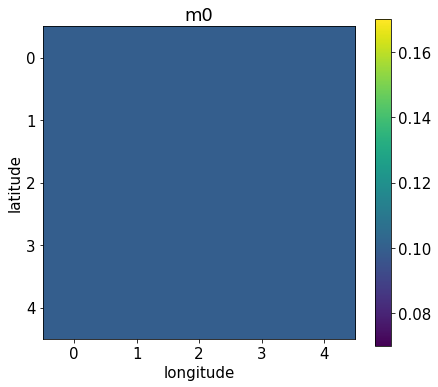

In [256]:
plt.figure(figsize=(7,6))
plt.imshow(dict_m['m0'].reshape((size_model, size_model)), vmin=0.07, vmax=0.17)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.title('m0')
plt.show()

## Data

In [206]:
dict_d = {
        'd0': d0,
        'C_d0': np.identity(len(d0))*np.std(d0)
    }

## G

In [207]:
G = np.array([get_dist_matrix(data).ravel() for data in dataset_1])


# Solving

In [228]:
def get_m_hat(dict_m, dict_d, G):
    m0, C_m0 = dict_m['m0'], dict_m['C_m0']
    d0, C_d0 = dict_d['d0'], dict_d['C_d0']    
    
    residuals = d0 - np.dot(G, m0)
    M = C_d0 + np.dot(np.dot(G, C_m0), np.transpose(G))
    
    return m0 + np.dot(np.dot(C_m0, np.transpose(G)), np.dot(np.linalg.inv(M), residuals))


m_hat = get_m_hat(dict_m, dict_d, G).reshape((size_model, size_model))


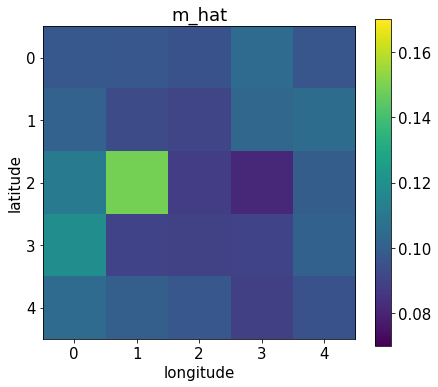

In [257]:
plt.figure(figsize=(7,6))
plt.imshow(m_hat, vmin=0.07, vmax=0.17)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.title('m_hat')
plt.show()

In [242]:
c_hat = [[1/val for val in row] for row in m_hat]

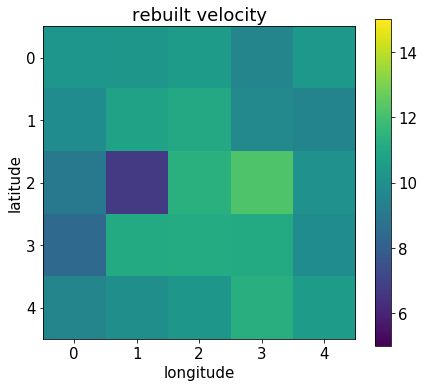

In [258]:
plt.figure(figsize=(7,6))
plt.imshow(c_hat, vmin=5, vmax=15)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar()
plt.title('rebuilt velocity')
plt.show()